# Day 6 - Asia

Shaded relief map of Philippines

- Elevation data: GMTED10 mean 7.5 arc-sec (via [USGS](https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm)), merged multiple files using QGIS
- Country shapefile: [Natural Earth](https://www.naturalearthdata.com/downloads/)
- Hillshades: downloaded using [earthpy library](https://earthpy.readthedocs.io/en/latest/index.html)
- Colours come from [palettable](https://jiffyclub.github.io/palettable/)

Full tutorial on shaded relief maps using python by Adam Symington [here](https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3)

In [1]:
import os
import configparser

import rasterio
import numpy as np
import geopandas as gpd

from shapely.geometry import mapping
from rasterio import mask as msk
import earthpy.spatial as es

from matplotlib import colors
import matplotlib.pyplot as plt
from palettable.scientific.diverging import Vik_14

from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

## Process data

In [3]:
# load shapefile
ne = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(ne, ne)))
phil = countries.loc[countries['ADMIN'] == 'Philippines']

In [4]:
# import terrain elevation data
file = rasterio.open('gmted_merged.tif')
dataset = file.read()
print(dataset.shape)

(1, 19200, 28800)


In [5]:
# function to clip elevation file to country outline
def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                           crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

topography, value_range = clip_raster(phil, file)

In [89]:
# get hillshades
hillshade = es.hillshade(topography[0], azimuth=120, altitude=30)
hillshade[hillshade == 191.25] = 35

In [13]:
# amend colour palette so that the highest value = given background colour
def get_colormap(hex_colors, bg_color):
    listed_colormap = colors.LinearSegmentedColormap.from_list('colorpalette', hex_colors, N=value_range) 
    bg_color = np.array(colors.to_rgba(bg_color))
    newcolors = listed_colormap(np.linspace(0, 1, int(value_range)))
    cmap_new = colors.ListedColormap(np.vstack((newcolors, bg_color)))
    return cmap_new

## Visualise

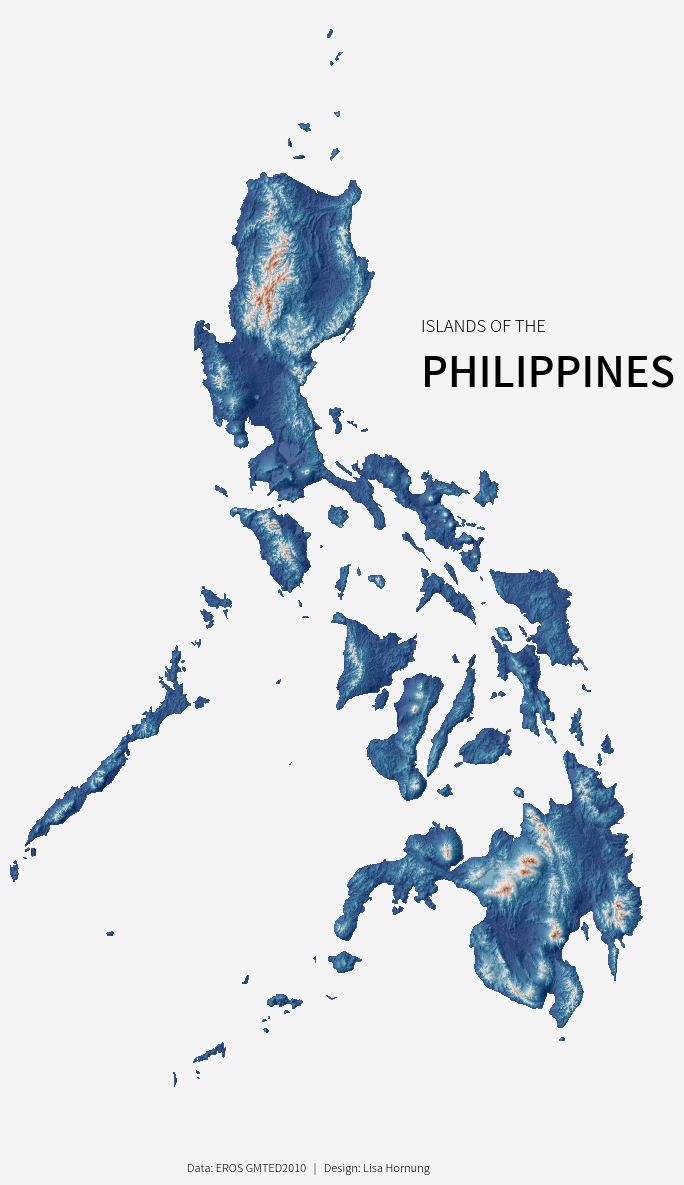

In [138]:
#set colours and font
hex_colors = Vik_14.hex_colors[:]
cmap_new = get_colormap(hex_colors, '#F0F0F0')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')

# plot
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor("#F4F4F4")

plt.imshow(topography[0], cmap=cmap_new, interpolation='nearest')
ax.imshow(hillshade, cmap="Greys", alpha=0.3, vmin=50)
ax.axis('off')

#title
plt.figtext(0.58, 0.65, "Islands of the".upper(), fontproperties=subtitle_font, fontsize=12,  ha="left")
plt.figtext(0.58, 0.61, "Philippines".upper(), fontproperties=title_font, fontsize=30,  ha="left")
plt.figtext(0.5, 0.05, "Data: EROS GMTED2010   |   Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="center")

plt.savefig("shaded-relief-philippines.png", bbox_inches='tight', pad_inches=1.5, facecolor="#F4F4F4")
plt.show()

## Playground

In [57]:
# played around with quite a few colour palettes before settling on one
from palettable.cartocolors.sequential import Magenta_7_r, PurpOr_5, Sunset_5_r, Teal_7, agGrnYl_5_r
from palettable.cartocolors.diverging import  Earth_7_r, TealRose_7, Temps_7
from palettable.cmocean.sequential import Deep_14, Matter_20_r, Dense_20
from palettable.matplotlib import Magma_20_r
from palettable.scientific.sequential import Buda_20_r, Nuuk_12, Tokyo_14
from palettable.scientific.diverging import Broc_14_r, Vik_14

In [ ]:
option1 = ["#FFFFFF","#FFFFFF", "#bc8dad"] + Matter_20_r.hex_colors[4:]